In [1]:
#Importing necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# Loading the dataset (if working on Google Colab)
drive.mount('/content/drive')
df_train = pd.read_csv('/content/drive/MyDrive/train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/test.csv')
#df_train.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
#working on local machine
#os.chdir('/Users/nikhilkudupudi/Projects - School & Work/FAI /Project/Tweet-Classification-for-Disaster-Detection/data')
#print(os.getcwd())

#df_train = pd.read_csv('train.csv')
#df_test = pd.read_csv('test.csv')
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


### Exploratory Data Analysis

In [5]:
# Summary of the target variable distribution
target_distribution = df_train['target'].value_counts(normalize=True)

# Summary of missing values in the training data
missing_values_train = df_train.isnull().sum()

# Summary of missing values in the test data
missing_values_test = df_test.isnull().sum()

print("Target Distribution:\n")
print(target_distribution)
print()
print("Missing Values in Training set:\n")
print(missing_values_train)
print()
print("Missing Values in Testing set:\n")
print(missing_values_test)

Target Distribution:

0    0.57034
1    0.42966
Name: target, dtype: float64

Missing Values in Training set:

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

Missing Values in Testing set:

id             0
keyword       26
location    1105
text           0
dtype: int64


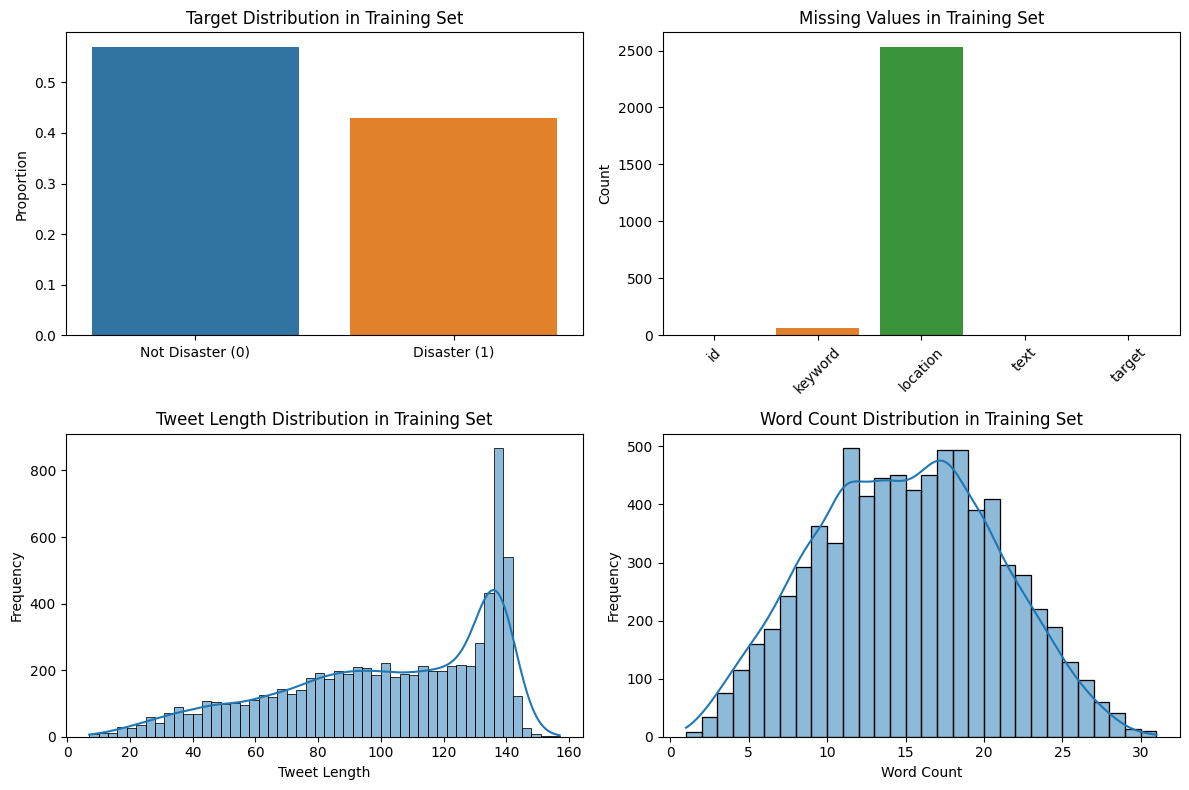

In [6]:
# Distribution of tweet lengths
tweet_length_train = df_train['text'].str.len()
tweet_length_test = df_test['text'].str.len()

# Distribution of number of words in tweets
word_count_train = df_train['text'].apply(lambda x: len(x.split()))
word_count_test = df_test['text'].apply(lambda x: len(x.split()))

# Create a figure to visualize EDA results
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Target distribution
sns.barplot(ax=axes[0, 0], x=target_distribution.index, y=target_distribution.values)
axes[0, 0].set_title('Target Distribution in Training Set')
axes[0, 0].set_ylabel('Proportion')
axes[0, 0].set_xticklabels(['Not Disaster (0)', 'Disaster (1)'])

# Missing values in training set
sns.barplot(ax=axes[0, 1], x=missing_values_train.index, y=missing_values_train.values)
axes[0, 1].set_title('Missing Values in Training Set')
axes[0, 1].set_ylabel('Count')
for item in axes[0, 1].get_xticklabels():
    item.set_rotation(45)

# Tweet length distribution
sns.histplot(tweet_length_train, bins=50, ax=axes[1, 0], kde=True)
axes[1, 0].set_title('Tweet Length Distribution in Training Set')
axes[1, 0].set_xlabel('Tweet Length')
axes[1, 0].set_ylabel('Frequency')

# Word count distribution
sns.histplot(word_count_train, bins=30, ax=axes[1, 1], kde=True)
axes[1, 1].set_title('Word Count Distribution in Training Set')
axes[1, 1].set_xlabel('Word Count')
axes[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [7]:
# Filling missing values for 'keyword' and 'location' with the string 'unknown'
df_train['keyword'].fillna('unknown', inplace=True)
df_train['location'].fillna('unknown', inplace=True)
df_test['keyword'].fillna('unknown', inplace=True)
df_test['location'].fillna('unknown', inplace=True)

# Stopwords list
stop_words = set(stopwords.words('english'))

# Lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to map NLTK's part-of-speech tags to the format expected by the lemmatizer
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [8]:
# Define the emoji pattern
emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"
                           u"\U0001F300-\U0001F5FF"
                           u"\U0001F680-\U0001F6FF"
                           u"\U0001F1E0-\U0001F1FF"
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)

# Function to clean the text data
def clean_text(text):

    # Expand contractions
    text = re.sub(r"can\'t", "cannot", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"It's", "It is", text)
    text = re.sub(r"let's", "let us", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"ain't", "am not", text)
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"There's", "There is", text)

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Convert to lowercase
    text = text.lower().strip()

    # Remove Emoji
    text = emoji_pattern.sub(r'', text)

    # Tokenization and stopwords removal
    tokens = word_tokenize(text)
    filtered_tokens = [token for token in tokens if token not in stop_words]

    # Part-of-speech tagging
    pos_tagged = nltk.pos_tag(filtered_tokens)

    # Lemmatization
    lemmatized_text = [lemmatizer.lemmatize(token, get_wordnet_pos(tag)) for token, tag in pos_tagged]

    return ' '.join(lemmatized_text)

# Cleaning the text column in the dataset
df_train['text_clean'] = df_train['text'].apply(clean_text)
df_test['text_clean'] = df_test['text'].apply(clean_text)

In [9]:
# Performing TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_tfidf = tfidf_vectorizer.fit_transform(df_train['text_clean'])
X_tfidf = X_tfidf.toarray()

In [10]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_tfidf, df_train['target'], test_size=0.2, random_state=42)

# Display the shapes of the output vectors
X_train.shape, X_val.shape

((6090, 5000), (1523, 5000))

# Model from stratch

In [11]:
import StratchModels

## Naive Bayes' Classifier

In [12]:
# Training the model
nb = StratchModels.MultinomialNaiveBayes()
nb.fit(X_train, y_train)

In [13]:
# Predicting on the validation set
y_pred = nb.predict(X_val)  # Convert sparse matrix to dense

In [14]:
# Evaluation Metrics
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.8017071569271176
Precision: 0.8382066276803118
Recall: 0.662557781201849
F1 Score: 0.7401032702237522


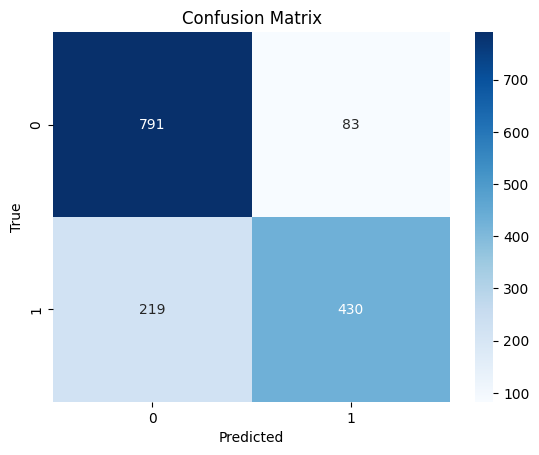

In [15]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_val, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Logistic Regression

In [16]:
lr_model = StratchModels.LogisticRegression()
lr_model.fit(X_train, y_train)

lr_ypred_train = lr_model.predict(X_train)
print('Training Accuracy: ', accuracy_score(y_train, lr_ypred_train))

training accuracy:  0.9825944170771757


In [21]:
lr_ypred_val = lr_model.predict(X_val)

print('Testing Accuracy: ', accuracy_score(y_val, lr_ypred_val))
print('F1-Score: ',f1_score(y_val,lr_ypred_val))

Testing Accuracy:  0.7130663164806303
F1-Score:  0.675092936802974


confusion_matrix: 
[[632 242]
 [195 454]]
Axes(0.125,0.11;0.62x0.77)


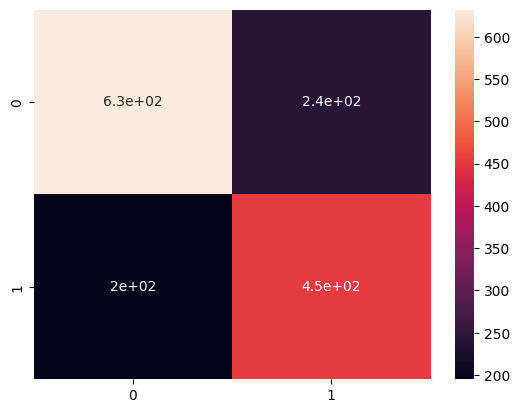

In [22]:
print('Confusion Matrix: ')
print(confusion_matrix(y_val, lr_ypred_val))
print(sns.heatmap(confusion_matrix(y_val, lr_ypred_val), annot=True))
plt.show()

## Random Forest